Epoch 1/100 | D Loss: 1.2271534204483032 | G Loss: 0.5616030693054199


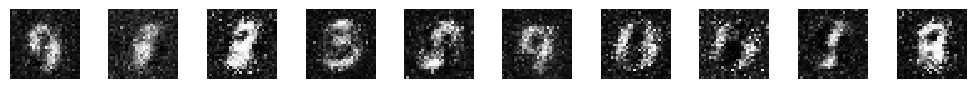

Epoch 10/100 | D Loss: 1.314955234527588 | G Loss: 0.7071425914764404


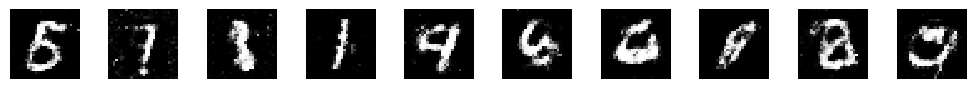

Epoch 50/100 | D Loss: 1.3810441493988037 | G Loss: 0.7080309391021729


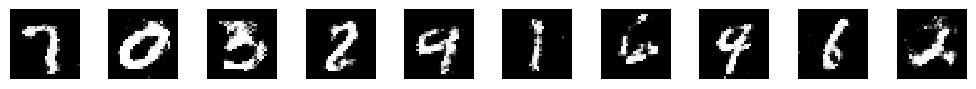

Epoch 100/100 | D Loss: 1.4017555713653564 | G Loss: 0.6879506707191467


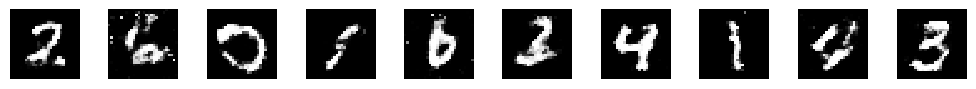

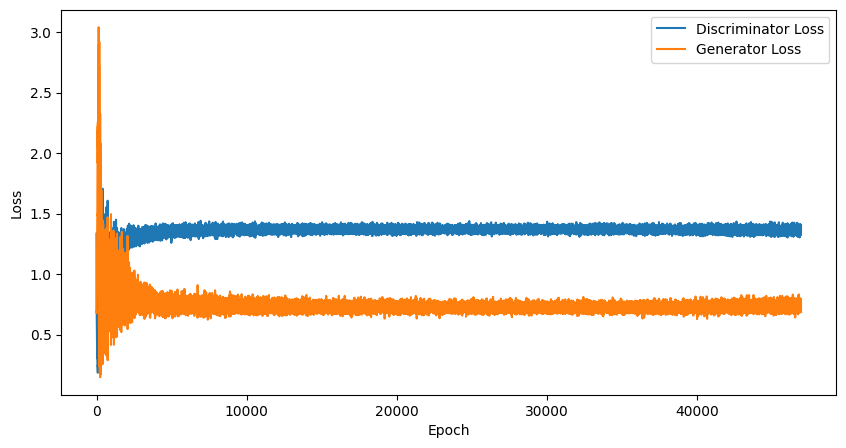

In [5]:
#simle GAN model to generate MNIST digits
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#pre-process the MNIST dataset to normalize between -1,1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
#load the MNIST dataset on my system and normalize the training data from it, I downloaded it to my ./data folder
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class Generator(nn.Module):
    def __init__(self):#construction method to initialize the model
        super(Generator, self).__init__()#calls constructor of parent class (nn.Module), to ensure proper initialization
        self.model = nn.Sequential(
            nn.Linear(100, 256),#linear stands for dense layer, takes in the 100 dim noise vector and outputs the 256 dim vector like from keras. This was my first time working with pytorch so i want to remind myself
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, x):#specifies how input data is passed through the model
        x = self.model(x)#passes input tensor, x, through the model
        x = x.view(x.size(0), 1, 28, 28)#reshapes the output tensor to have shape (batch_size, 1, 28, 28)
        return x#returns reshaped output tensor

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)#flattens the input tensor so that the shape will be (batch_size, 28*28)
        x = self.model(x)
        return x
#initilizing the generator and discriminator
gen = Generator()
disc = Discriminator()

#loss function and optimizers
criterion = nn.BCELoss()#using binary cross entropy loss
optimizer_g = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))#betas control exponential decay rates for moment estimates of the gradients in order to help smooth the gradients and improve convergence of the optimization process. (first moment, second moment)
optimizer_d = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

#parameters
epochs = 100
sample_interval = [1, 10, 50, 100] #progress checkpoints for visualization

#loss placeholders
d_losses = []
g_losses = []

#function to generate and show images at checkpoints
def plot_generated_images(epoch, gen, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = torch.randn(examples, 100)#random noise vector, each sampled from a standard normal distribution
    generated_images = gen(noise).detach().cpu().numpy()#pass the noise through the generator to generate images, detaches from graph to move the tensor to the cpu and convert to a numpy array
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


#training the GAN
for epoch in range(epochs):
    d_loss_epoch = 0.0
    g_loss_epoch = 0.0
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)#set in case any batches are smaller than 128, as it is accounting for real images from dataset
        
        #training discriminator
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        #real images
        outputs = disc(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        #fake images
        noise = torch.randn(batch_size, 100)
        fake_images = gen(noise)#gen makes em
        outputs = disc(fake_images.detach())#disc judges em
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        #backprop and optimize
        d_loss = d_loss_real + d_loss_fake #total loss for disc
        optimizer_d.zero_grad()#zero the gradients before backpropagation per batch
        d_loss.backward()#backpropagation with respect to the discs parameters usng chain rule
        optimizer_d.step()#updates the weights of the disc using computed gradients and optimizer adjusts params to minimize loss

        #training the generator
        noise = torch.randn(batch_size, 100)
        fake_images = gen(noise)
        outputs = disc(fake_images)
        g_loss = criterion(outputs, real_labels)

        #backprop and optimize
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    if (epoch + 1) in sample_interval:
        print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_losses[-1]} | G Loss: {g_losses[-1]}")
        plot_generated_images(epoch + 1, gen)

#loss history, the x axis shows the epoch number and the y axis shows the loss value with the epoch number around 46000. This is because the x axis counted the nymber of batches per epoch as individual epochs.
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#saved the model to my system so i could call it and use it for the latent space interpolation
#torch.save(gen.state_dict(), r'D:\RIT FALL2024\Advanced Topics ML with Dima Derah\Assignment2\GAN\generator.pth')
#torch.save(disc.state_dict(), r'D:\RIT FALL2024\Advanced Topics ML with Dima Derah\Assignment2\GAN\discriminator.pth')

Files already downloaded and verified
Epoch [1/25], Step [1/391], LossD: 1.3817, LossG: 1.5319
Epoch [1/25], Step [101/391], LossD: 0.1600, LossG: 5.0549
Epoch [1/25], Step [201/391], LossD: 0.3862, LossG: 2.9608
Epoch [1/25], Step [301/391], LossD: 0.7527, LossG: 4.0368
Epoch [2/25], Step [1/391], LossD: 0.6701, LossG: 4.4862
Epoch [2/25], Step [101/391], LossD: 1.3726, LossG: 2.0324
Epoch [2/25], Step [201/391], LossD: 0.4437, LossG: 2.4989
Epoch [2/25], Step [301/391], LossD: 0.6356, LossG: 2.4556
Epoch [3/25], Step [1/391], LossD: 0.5590, LossG: 3.1443
Epoch [3/25], Step [101/391], LossD: 0.5595, LossG: 3.5284
Epoch [3/25], Step [201/391], LossD: 0.4740, LossG: 3.2345
Epoch [3/25], Step [301/391], LossD: 0.4174, LossG: 2.7867
Epoch [4/25], Step [1/391], LossD: 0.4243, LossG: 2.6295
Epoch [4/25], Step [101/391], LossD: 0.4645, LossG: 2.3611
Epoch [4/25], Step [201/391], LossD: 0.7374, LossG: 3.4030
Epoch [4/25], Step [301/391], LossD: 1.8658, LossG: 3.3858
Epoch [5/25], Step [1/391]

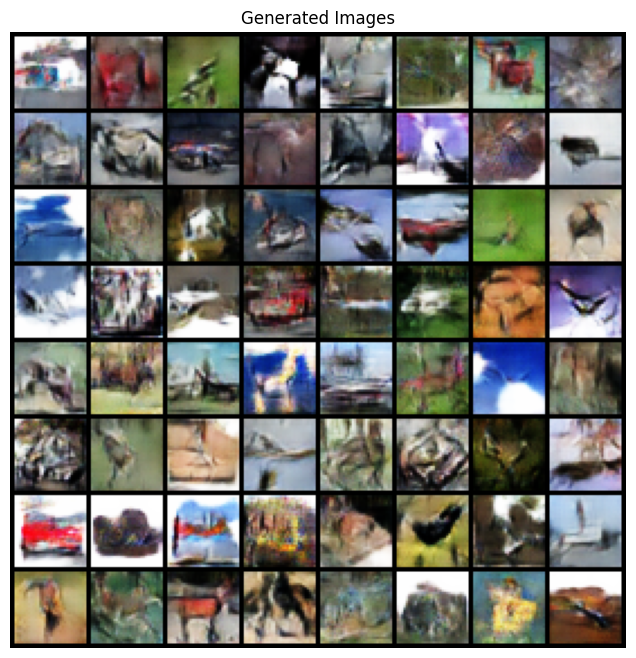

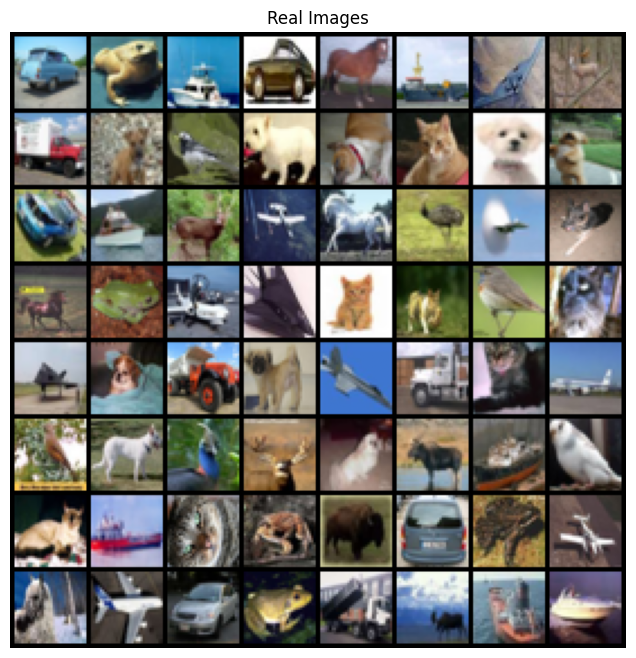

In [26]:
#working DCGAN code for CIFAR10 dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

external_drive_path = r"D:\RIT FALL2024\Advanced Topics ML with Dima Derah\Assignment2\CIFAR10"

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #normalize to [-1, 1] from [0,255]
])

#loading and initializing the CIFAR-10 dataset
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root=external_drive_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self, nz):#nz is the size of the latent vector(input noise vector)
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, 4, 1, 0, bias=False),#for these layers the first argument is the number of input channels, the second is the number of output channels, the third is the kernel size, the fourth is the stride, and the fifth is the padding
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),#padding is set to 1 to ensure the output size is the same as the input size since stride is set to 2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),#reduces output channels to 3 for the images of CIFAR10 since they are RGB
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),#produces single output to classify the image as real or fake
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)

#device configuration, used cpu because i dont have a gpu and was having issues trying to use cuda
device = torch.device("cpu")

#hyperparameters
nz = 100  #size of z latent vector (generator input)
lr = 0.0002
beta1 = 0.5

#initialize generator and discriminator for use
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

#loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

num_epochs = 25
fixed_noise = torch.randn(64, nz, 1, 1, device=device)#fixed noise vector to visualize the progress of the generator (batch size, latent vector size, height, width)

for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        #train discriminator
        netD.zero_grad()#reset gradients so they dont accumulate
        
        #real batch
        real_images, _ = data
        real_images = real_images.to(device)#this moves the data to the device, in this case the cpu. there may be a "smarter way" to do this but this is what i found
        batch_size = real_images.size(0)
        labels = torch.ones(batch_size, 1).to(device)#tensor of 1's so that we know these are "real"
        output = netD(real_images)
        lossD_real = criterion(output, labels)
        lossD_real.backward()#backprop step
        
        #fake batch
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(0)
        output = netD(fake_images.detach())#detach so that the gradients do not flow back through the generator
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        
        optimizerD.step()
        
        #train generator
        netG.zero_grad()
        labels.fill_(1)#labels set to 1 so that the generator tries to fool the discriminator
        output = netD(fake_images)
        lossG = criterion(output, labels)
        lossG.backward()
        
        optimizerG.step()
        
        #logging training progress every 100 steps
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], LossD: {lossD_real+lossD_fake:.4f}, LossG: {lossG:.4f}')

#generate images using fixed noise
with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0))
plt.show()

#CIFAR-10 images for comparison
real_batch = next(iter(trainloader))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(make_grid(real_batch[0][:64], padding=2, normalize=True).permute(1, 2, 0))
plt.show()


C:\Users\jason\AppData\Local\Temp\ipykernel_46528\1423170723.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.load_state_dict(torch.load(r'D:\RIT FALL2024\Advanced T

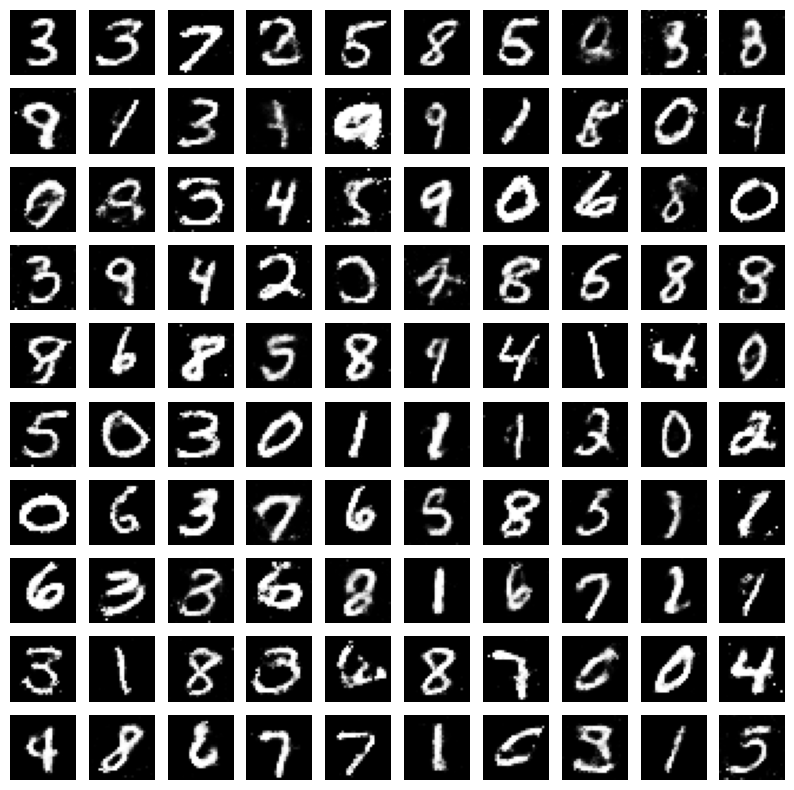

IntText(value=0, description='Index of Start:')

IntText(value=0, description='Index of End:')

Button(description='Submit', style=ButtonStyle())

Output()

In [13]:
#Latent space linear interpolation for simple GAN and MNIST
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import ipywidgets as widgets
from IPython.display import display

#even though we are loading the pretrained GAN, we still need to define the generator model to ensure the exact same architecture is used in order to load the pre-trained weights correctly
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

device = torch.device("cpu")

gen = Generator().to(device)

#load the trained generator model
gen.load_state_dict(torch.load(r'D:\RIT FALL2024\Advanced Topics ML with Dima Derah\Assignment2\GAN\generator.pth', map_location=device))
gen.eval()

def generate_images(gen, num_images=100):
    noise = torch.randn(num_images, 100).to(device)
    generated_images = gen(noise).detach().cpu().numpy()
    generated_images = generated_images.reshape(num_images, 28, 28)
    return generated_images, noise

generated_images, latent_vectors = generate_images(gen, num_images=100)

plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.show()

#wanted to allow the user to select the indices of the latent vectors to interpolate between so i used ipywidgets to create a simple GUI
index_start_widget = widgets.IntText(value=0, description='Index of Start:', min=0, max=99)
index_end_widget = widgets.IntText(value=0, description='Index of End:', min=0, max=99)
button = widgets.Button(description="Submit")
output = widgets.Output()

display(index_start_widget, index_end_widget, button, output)

#function to get the selected indices, remember they begin at 0 increasing from left to right top to bottom
def get_selected_indices(b):
    with output:
        output.clear_output()
        index_start = index_start_widget.value
        index_end = index_end_widget.value
        print(f"Selected indices - Start: {index_start}, End: {index_end}")
        #select the corresponding latent vectors and add a dimension to match the generator input shape
        z1 = latent_vectors[index_start].unsqueeze(0)
        z2 = latent_vectors[index_end].unsqueeze(0)
        #interpolate between the two latent vectors using function below
        interpolated_images = interpolate_latent_space(z1, z2)

        plt.figure(figsize=(20, 8))
        plt.axis("off")
        plt.title("Latent Space Interpolation from Start to End")
        for i, img in enumerate(interpolated_images[:10]):
            plt.subplot(2, 10, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis("off")
        for i, img in enumerate(interpolated_images[10:]):
            plt.subplot(2, 10, i + 11)
            plt.imshow(img, cmap='gray')
            plt.axis("off")
        plt.show()

#linearly interpolate between two latent vectors
def interpolate_latent_space(z1, z2, num_steps=20):
    interpolated_images = []
    for alpha in np.linspace(0, 1, num_steps):
        z = (1 - alpha) * z1 + alpha * z2#linear interpolation formula
        interpolated_images.append(gen(z).detach().cpu().numpy().reshape(28, 28))#generate the image and reshape to 28x28
    return interpolated_images

#allows for multiple choices by adding functionality to the button
button.on_click(get_selected_indices)

Epoch 1, Loss: 162.1813, RE: 148.2985, KLD: 13.8829
Epoch 2, Loss: 124.5984, RE: 107.9432, KLD: 16.6552
Epoch 3, Loss: 119.4035, RE: 102.3475, KLD: 17.0560
Epoch 4, Loss: 116.7835, RE: 99.4143, KLD: 17.3692
Epoch 5, Loss: 115.1693, RE: 97.5480, KLD: 17.6213
Epoch 6, Loss: 113.9827, RE: 96.1988, KLD: 17.7838
Epoch 7, Loss: 113.0375, RE: 95.1352, KLD: 17.9024
Epoch 8, Loss: 112.3141, RE: 94.2994, KLD: 18.0147
Epoch 9, Loss: 111.7464, RE: 93.6394, KLD: 18.1070
Epoch 10, Loss: 111.2281, RE: 93.0460, KLD: 18.1821
Epoch 11, Loss: 110.6954, RE: 92.4521, KLD: 18.2432
Epoch 12, Loss: 110.2970, RE: 91.9982, KLD: 18.2988
Epoch 13, Loss: 109.9015, RE: 91.5559, KLD: 18.3456
Epoch 14, Loss: 109.5138, RE: 91.1420, KLD: 18.3718
Epoch 15, Loss: 109.2025, RE: 90.7879, KLD: 18.4146


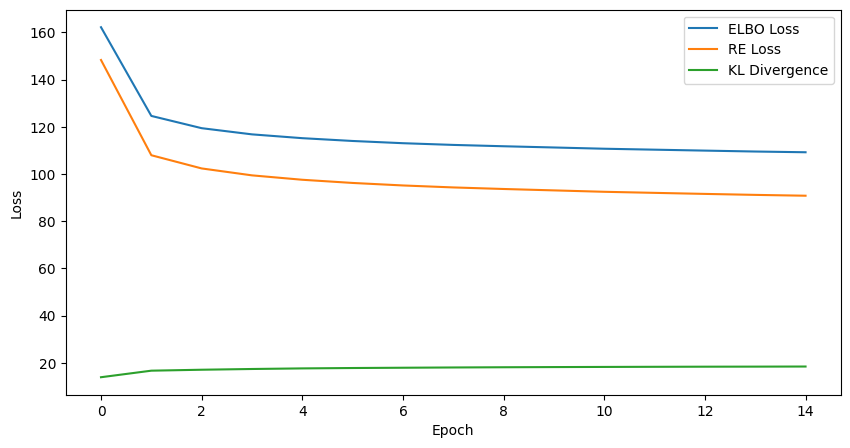

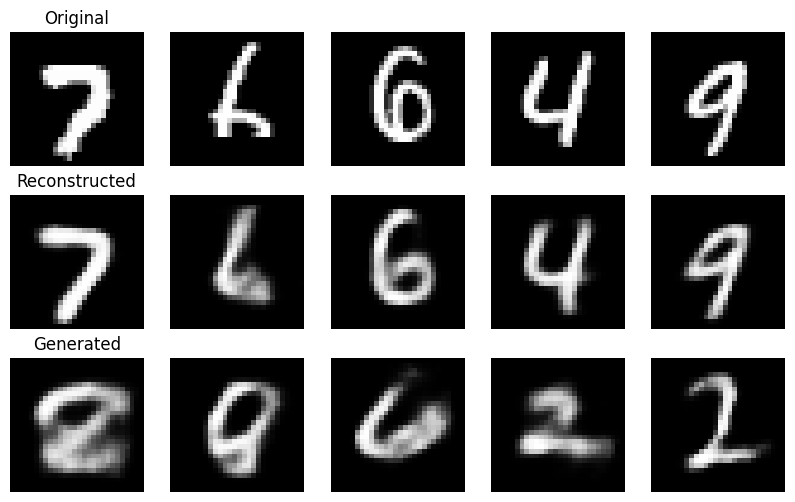

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    RE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RE + KLD, RE, KLD

transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

#training model
epochs = 15
train_loss = []
RE_loss = []
kld_loss = []

for epoch in range(epochs):
    vae.train()#sets the vae to training mode
    train_loss_epoch = 0#initializes epoch losses to 0
    RE_loss_epoch = 0
    kld_loss_epoch = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)#gets the reconstructed images, mean and log variance of the latent space
        loss, RE, kld = loss_function(recon_batch, data, mu, logvar)
        loss.backward()#backpropagation
        train_loss_epoch += loss.item()
        RE_loss_epoch += RE.item() #reconstruction error loss accumulation
        kld_loss_epoch += kld.item()
        optimizer.step()#updates model parameters to minimize loss
    train_loss.append(train_loss_epoch / len(train_loader.dataset))#avg losses over epochs
    RE_loss.append(RE_loss_epoch / len(train_loader.dataset))
    kld_loss.append(kld_loss_epoch / len(train_loader.dataset))
    print(f'Epoch {epoch + 1}, Loss: {train_loss[-1]:.4f}, RE: {RE_loss[-1]:.4f}, KLD: {kld_loss[-1]:.4f}')

#ELBO loss, Reconstruction error and KL-divergence
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='ELBO Loss')
plt.plot(RE_loss, label='RE Loss')
plt.plot(kld_loss, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#visualizing the original, reconstructed and generated images
vae.eval()
with torch.no_grad():
    data, _ = next(iter(train_loader))
    recon_batch, _, _ = vae(data)
    z = torch.randn(15, 10)
    generated_images = vae.decode(z).view(-1, 1, 28, 28)

    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    axes[2, 0].set_title('Generated')
    for i in range(5):
        axes[0, i].imshow(data[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_batch[i].view(28, 28), cmap='gray')
        axes[1, i].axis('off')
        axes[2, i].imshow(generated_images[i].view(28, 28), cmap='gray')
        axes[2, i].axis('off')
    plt.show()

Epoch 1, Loss: 161.9177, RE: 148.5772, KLD: 13.3405
Epoch 2, Loss: 123.9984, RE: 107.3333, KLD: 16.6651
Epoch 3, Loss: 119.0046, RE: 101.8536, KLD: 17.1510
Epoch 4, Loss: 116.5074, RE: 99.0477, KLD: 17.4597
Epoch 5, Loss: 114.9268, RE: 97.2389, KLD: 17.6879
Epoch 6, Loss: 113.7865, RE: 95.9354, KLD: 17.8511
Epoch 7, Loss: 112.8891, RE: 94.8886, KLD: 18.0005
Epoch 8, Loss: 112.0777, RE: 93.9934, KLD: 18.0843
Epoch 9, Loss: 111.4845, RE: 93.3020, KLD: 18.1825
Epoch 10, Loss: 110.9352, RE: 92.6695, KLD: 18.2656
Epoch 11, Loss: 110.5066, RE: 92.1721, KLD: 18.3345
Epoch 12, Loss: 110.0249, RE: 91.6451, KLD: 18.3798
Epoch 13, Loss: 109.6219, RE: 91.1837, KLD: 18.4382
Epoch 14, Loss: 109.2603, RE: 90.8043, KLD: 18.4560
Epoch 15, Loss: 108.9554, RE: 90.4381, KLD: 18.5173


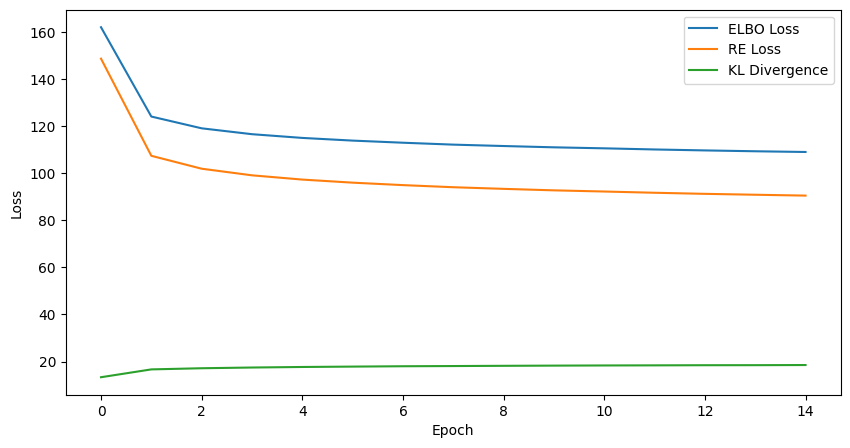

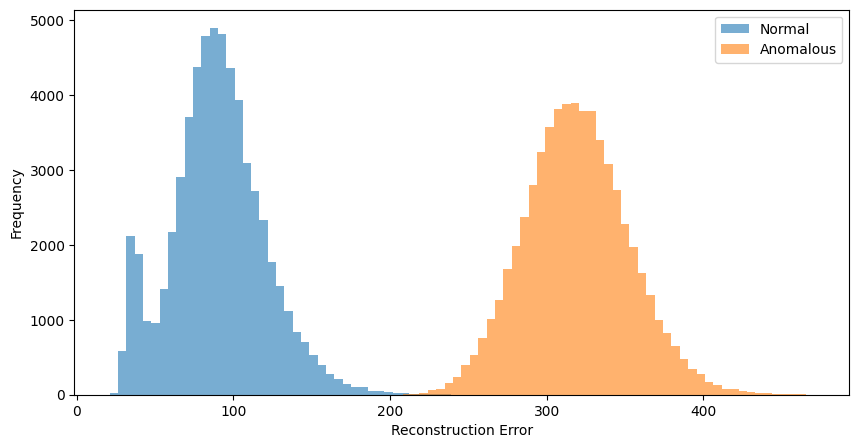

Set threshold for anomaly detection: 0.95


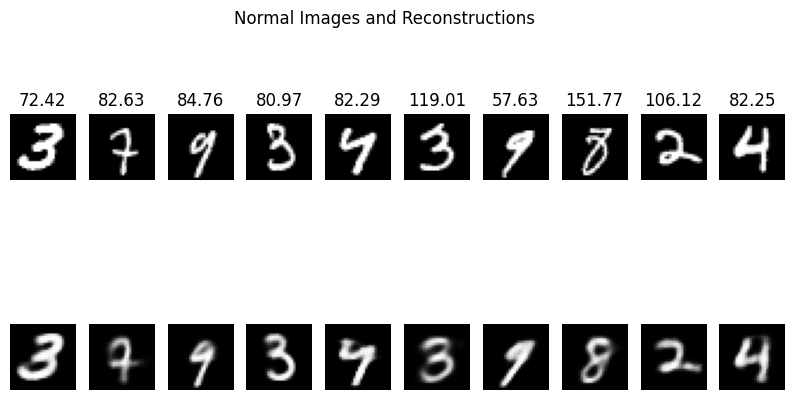

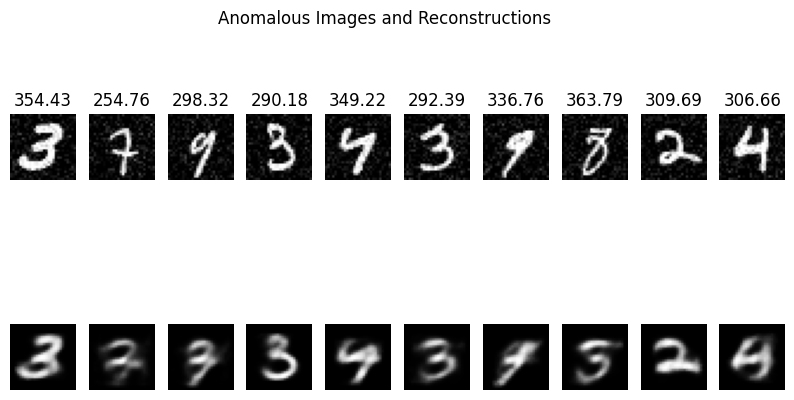

In [16]:
#VAE model
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)#maps the hidden layer to the mean of the latent space
        self.fc22 = nn.Linear(hidden_dim, latent_dim)#maps the hidden layer to the log variance of the latent space
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))#apply activation function to first fc layer 
        return self.fc21(h1), self.fc22(h1)#returns mean and logvar of latent space 

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)#randm epsilon sampled from normal distribution
        return mu + eps * std

    def decode(self, z):#latent vector z sampled from latent space
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))#returns reconstructed data (image in this case)

    def forward(self, x):#this returns the result of the decode function and assigns the first element of the tuple to "recon_x"
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

#loss function
def loss_function(recon_x, x, mu, logvar):
    RE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RE + KLD, RE, KLD

transform = transforms.Compose([
    transforms.ToTensor(),  #converts images to tensors and normalizes to [0, 1]
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

#initialize model, optimizer
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

#training model
epochs = 15
train_loss = []
RE_loss = []
kld_loss = []

for epoch in range(epochs):
    vae.train()#sets the vae to training mode
    train_loss_epoch = 0#initializes epoch losses to 0
    RE_loss_epoch = 0
    kld_loss_epoch = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)#gets the reconstructed images, mean and log variance of the latent space
        loss, RE, kld = loss_function(recon_batch, data, mu, logvar)
        loss.backward()#backpropagation
        train_loss_epoch += loss.item()
        RE_loss_epoch += RE.item() #reconstruction error loss accumulation
        kld_loss_epoch += kld.item()
        optimizer.step()#updates model parameters to minimize loss
    train_loss.append(train_loss_epoch / len(train_loader.dataset))#avg losses over epochs
    RE_loss.append(RE_loss_epoch / len(train_loader.dataset))
    kld_loss.append(kld_loss_epoch / len(train_loader.dataset))
    print(f'Epoch {epoch + 1}, Loss: {train_loss[-1]:.4f}, RE: {RE_loss[-1]:.4f}, KLD: {kld_loss[-1]:.4f}')

#save the trained VAE model
#save_path = r'D:\RIT FALL2024\Advanced Topics ML with Dima Derah\Assignment2\GAN\vae_mnist.pth'
#torch.save(vae.state_dict(), save_path)
#print(f'Model saved to {save_path}')

#ELBO loss, Reconstruction error and KL-divergence
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='ELBO Loss')
plt.plot(RE_loss, label='RE Loss')
plt.plot(kld_loss, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#adding gaussian noise to create anomalous images
def add_noise(images, noise_factor=0.1):
    noisy_images = images + noise_factor * torch.randn(*images.shape)#random noise with same shape as images
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

#function to evaluate reconstruction error on normal and nomaous images 
def evaluate_reconstruction_error(vae, data_loader, noise_factor=0.1):#noise is taken from the std of gaussian noise
    vae.eval()#set vae to eval mode
    normal_errors = []
    anomalous_errors = []
    normal_reconstructions = []
    anomalous_reconstructions = []
    normal_data = []
    noisy_data = []
    with torch.no_grad():#gradients are not required for the following portion of the code
        for data, _ in data_loader:
            #normal images
            recon_batch_normal, _, _ = vae(data)
            recon_error_normal = nn.functional.binary_cross_entropy(recon_batch_normal, data.view(-1, 784), reduction='none')
            normal_errors.extend(recon_error_normal.sum(dim=1).cpu().numpy())#RE sumed over all pixels and converted to numpy array
            normal_reconstructions.append(recon_batch_normal)
            normal_data.append(data)

            #anomalous images
            noisy_data_batch = add_noise(data, noise_factor)
            recon_batch_anomalous, _, _ = vae(noisy_data_batch)
            recon_error_anomalous = nn.functional.binary_cross_entropy(recon_batch_anomalous, noisy_data_batch.view(-1, 784), reduction='none')
            anomalous_errors.extend(recon_error_anomalous.sum(dim=1).cpu().numpy())
            anomalous_reconstructions.append(recon_batch_anomalous)
            noisy_data.append(noisy_data_batch)
    return normal_errors, anomalous_errors, torch.cat(normal_reconstructions), torch.cat(anomalous_reconstructions), torch.cat(normal_data), torch.cat(noisy_data)

#actually evaluate reconstruction error on normal and anomalous images
normal_errors, anomalous_errors, recon_batch_normal, recon_batch_anomalous, normal_data, noisy_data = evaluate_reconstruction_error(vae, train_loader)

#plot distribution of reconstruction errors
plt.figure(figsize=(10, 5))
plt.hist(normal_errors, bins=50, alpha=0.6, label='Normal')
plt.hist(anomalous_errors, bins=50, alpha=0.6, label='Anomalous')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#threshold to classify images as "anomalous" or "normal" 
threshold = 0.95  
print(f'Set threshold for anomaly detection: {threshold:.2f}')

#function to visualize normal and anomalous images with their reconstruction errors
def visualize_anomalies(normal_data, noisy_data, recon_batch_normal, recon_batch_anomalous, normal_errors, anomalous_errors, threshold):
    #normal images and their reconstructions
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(normal_data[i][0], cmap='gray')
        plt.title(f'{normal_errors[i]:.2f}')
        plt.axis('off')
        plt.subplot(2, 10, i + 11)
        plt.imshow(recon_batch_normal[i].view(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle('Normal Images and Reconstructions')
    plt.show()

    #anomalous images and their reconstructions
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(noisy_data[i][0], cmap='gray')
        plt.title(f'{anomalous_errors[i]:.2f}')
        plt.axis('off')
        plt.subplot(2, 10, i + 11)
        plt.imshow(recon_batch_anomalous[i].view(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle('Anomalous Images and Reconstructions')
    plt.show()

visualize_anomalies(normal_data, noisy_data, recon_batch_normal, recon_batch_anomalous, normal_errors, anomalous_errors, threshold)

In [12]:
#code to save a new VAE model with latent_dim=2 and save it to use for the final portion of the coding assignment. I used higher dimensions for the previous models to ensure better performance
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__() 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 15
train_loss = []
bce_loss = []
kld_loss = []

for epoch in range(epochs):
    vae.train()
    train_loss_epoch = 0
    bce_loss_epoch = 0
    kld_loss_epoch = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss_epoch += loss.item()
        bce_loss_epoch += bce.item()
        kld_loss_epoch += kld.item()
        optimizer.step()
    train_loss.append(train_loss_epoch / len(train_loader.dataset))
    bce_loss.append(bce_loss_epoch / len(train_loader.dataset))
    kld_loss.append(kld_loss_epoch / len(train_loader.dataset))
    print(f'Epoch {epoch + 1}, Loss: {train_loss[-1]:.4f}, BCE: {bce_loss[-1]:.4f}, KLD: {kld_loss[-1]:.4f}')

#save the trained VAE model with latent_dim=2
save_path = r'D:\RIT FALL2024\Advanced Topics ML with Dima Derah\Assignment2\GAN\vae_mnist_latent2.pth'
torch.save(vae.state_dict(), save_path)
print(f'Model saved to {save_path}')

Epoch 1, Loss: 190.0790, BCE: 184.2017, KLD: 5.8772
Epoch 2, Loss: 168.7141, BCE: 163.2980, KLD: 5.4161
Epoch 3, Loss: 164.2751, BCE: 158.8027, KLD: 5.4724
Epoch 4, Loss: 161.7322, BCE: 156.2089, KLD: 5.5233
Epoch 5, Loss: 159.9006, BCE: 154.3155, KLD: 5.5852
Epoch 6, Loss: 158.5110, BCE: 152.8815, KLD: 5.6296
Epoch 7, Loss: 157.3126, BCE: 151.6482, KLD: 5.6644
Epoch 8, Loss: 156.3069, BCE: 150.6145, KLD: 5.6923
Epoch 9, Loss: 155.5527, BCE: 149.8176, KLD: 5.7352
Epoch 10, Loss: 154.7675, BCE: 149.0011, KLD: 5.7664
Epoch 11, Loss: 154.1340, BCE: 148.3272, KLD: 5.8068
Epoch 12, Loss: 153.5636, BCE: 147.7485, KLD: 5.8151
Epoch 13, Loss: 153.1190, BCE: 147.2655, KLD: 5.8535
Epoch 14, Loss: 152.6223, BCE: 146.7312, KLD: 5.8911
Epoch 15, Loss: 152.2248, BCE: 146.3215, KLD: 5.9034
Model saved to D:\RIT FALL2024\Advanced Topics ML with Dima Derah\Assignment2\GAN\vae_mnist_latent2.pth


C:\Users\jason\AppData\Local\Temp\ipykernel_26488\1677778837.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(r'D:\RIT FALL2024\Advanced T

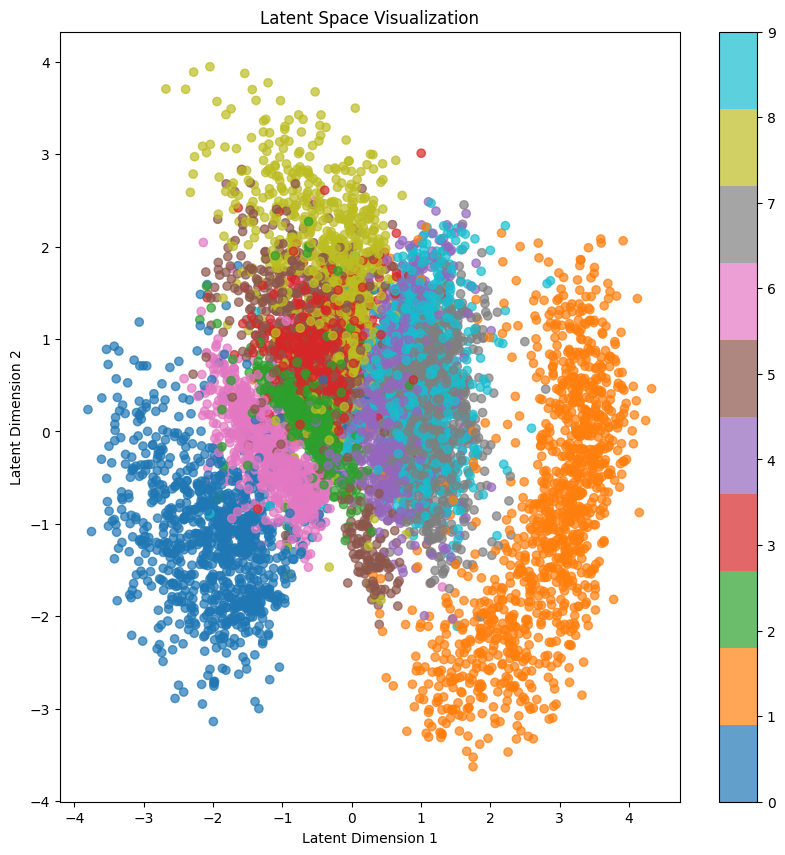

In [13]:
#Latent Space Visualization
#define the VAE model with latent_dim=2
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2): #again defining the model even though we are loading the pre trained weights to ensure the same architecture is used
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae = VAE()
vae.load_state_dict(torch.load(r'D:\RIT FALL2024\Advanced Topics ML with Dima Derah\Assignment2\GAN\vae_mnist_latent2.pth'))
vae.eval()

test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#encodes the test dataset to obtain latent vectors to plot
latent_vectors = []
labels = []
with torch.no_grad():
    for data, target in test_loader:
        mu, logvar = vae.encode(data.view(-1, 784))
        z = vae.reparameterize(mu, logvar)
        latent_vectors.append(z)
        labels.append(target)

latent_vectors = torch.cat(latent_vectors).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

plt.figure(figsize=(10, 10))
scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()